# `get_inferred_rpr_or_tr.ipynb`

### Author: Anthony Hein

#### Last updated: 10/19/2021

# Overview:

Previously, we filled in `RPR`, `OR`, and `TR` with the global average where this statistic was unknown under the premise that we expect an unseen horse to be about average. This in fact cannot be done because different races have different levels of horses. One race may have above average horses and another race may have below average horses. Instead, it would be more accurate to fill in the values for `RPR`, `OR`, and `TR` as the average _within a race_.

To correct this, we must know which races we inferred this for in the first place, which is accomplished by this notebook.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import math
import re
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `horses_all_trim_intxn.csv`

In [3]:
horses_all_trim_intxn = pd.read_csv(f"{BASE_DIR}/data/csv/horses_all_trim_intxn.csv", low_memory=False) 
horses_all_trim_intxn.head()

,rid,horseName,age,saddle,decimalPrice,trainerName,jockeyName,position,positionL,dist,outHandicap,RPR,TR,OR,father,mother,gfather,weight
0,267255,Going For Broke,3.0,4.0,0.100000,P C Haslam,Seb Sanders,1,NaN,NaN,NaN,72.0,62.0,62.0,Simply Great,Empty Purse,Pennine Walk,58
1,267255,Pinchincha,3.0,3.0,0.266667,Dave Morris,Tony Clark,2,4,NaN,NaN,66.0,56.0,65.0,Priolo,Western Heights,Shirley Heights,60
2,267255,Skelton Sovereign,3.0,5.0,0.142857,Reg Hollinshead,D Griffiths,3,3,7.0,NaN,55.0,40.0,60.0,Contract Law,Mrs Lucky,Royal Match,55
3,267255,Fast Spin,3.0,6.0,0.380952,David Barron,Tony Culhane,4,7,14.0,NaN,38.0,30.0,59.0,Formidable I,Topwinder,Topsider,57
4,267255,As-Is,3.0,2.0,0.166667,Mark Johnston,J Weaver,5,7,21.0,NaN,29.0,21.0,65.0,Lomond,Capriati I,Diesis,60


In [4]:
horses_all_trim_intxn.shape

(4107315, 18)

---

## Load  `horses_augment_times.csv`

In [5]:
horses_augment_times = pd.read_csv(f"{BASE_DIR}/data/csv/horses_augment_times.csv", low_memory=False) 
horses_augment_times.head()

,rid,horseName,age,saddle,decimalPrice,trainerName,jockeyName,position,outHandicap,RPR,TR,OR,father,mother,gfather,weight,time
0,302858,Kings Return,6.0,4.0,0.600000,W P Mullins,D J Casey,1,0.0,102.00000,51.591987,79.654604,King's Ride,Browne's Return,Deep Run,73,277.200000
1,302858,Majestic Red I,6.0,5.0,0.047619,John Hackett,Conor O'Dwyer,2,0.0,94.00000,51.591987,79.654604,Long Pond,Courtlough Lady,Giolla Mear,73,278.679948
2,302858,Clearly Canadian,6.0,2.0,0.166667,D T Hughes,G Cotter,3,0.0,92.00000,51.591987,79.654604,Nordico,Over The Seas,North Summit,71,278.957438
3,302858,Bernestic Wonder,8.0,1.0,0.058824,E McNamara,J Old Jones,4,0.0,71.87665,51.591987,79.654604,Roselier,Miss Reindeer,Reindeer,73,284.507242
4,302858,Beauty's Pride,5.0,6.0,0.038462,J J Lennon,T Martin,5,0.0,71.87665,51.591987,79.654604,Noalto,Elena's Beauty,Tarqogan,66,290.057045


In [6]:
horses_augment_times.shape

(194573, 17)

---

## Drop Columns

In [7]:
horses_all_trim_intxn = horses_all_trim_intxn[['rid', 'horseName', 'RPR', 'TR', 'OR']]

In [8]:
horses_augment_times = horses_augment_times[['rid', 'horseName']]

---

## Get Intersection

In [9]:
horses_all_working = horses_all_trim_intxn.merge(horses_augment_times, on=['rid', 'horseName'])
horses_all_working.head(10)

,rid,horseName,RPR,TR,OR
0,302858,Kings Return,102.0,NaN,NaN
1,302858,Majestic Red I,94.0,NaN,NaN
2,302858,Clearly Canadian,92.0,NaN,NaN
3,302858,Bernestic Wonder,NaN,NaN,NaN
4,302858,Beauty's Pride,NaN,NaN,NaN
5,302858,Graignamanagh,NaN,NaN,NaN
6,291347,Antonin,157.0,NaN,NaN
7,291347,King Of The Gales,NaN,NaN,NaN
8,291347,Carrigeen Kerria,NaN,NaN,NaN
9,291347,Fissure Seal,NaN,NaN,NaN


In [10]:
horses_all_working.shape

(194573, 5)

---

## Get NaN Values

Define the following mapping:
* 0: no values
* 1: only OR
* 2: only TR
* 3: OR and TR
* 4: only RPR
* 5: OR and RPR
* 6: TR and RPR
* 7: all

In [11]:
d = {}

for idx, row in tqdm(horses_all_working.iterrows()):
    zeroth = not pd.isna(row['OR'])
    oneth = not pd.isna(row['TR'])
    twoth = not pd.isna(row['RPR'])
    code = int(zeroth) + 2 * int(oneth) + 4 * int(twoth)
    d[idx] = code

194573it [00:10, 19016.34it/s]


In [12]:
d[0]

4

In [13]:
d[3]

0

(array([ 7869.,  5677.,   309.,     0.,   165., 30263.,     0., 33112.,
        41385., 75793.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

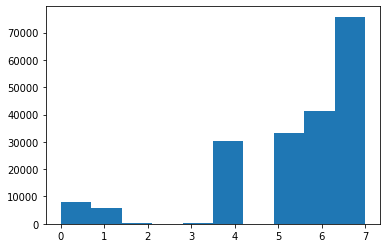

In [14]:
plt.hist([v for k,v in d.items()])

Fortunately, it looks like this information is mostly available.

---

## Write to File in `utils`

In [15]:
s = f"NAN_VALUES = {d}"
s[:100]

'NAN_VALUES = {0: 4, 1: 4, 2: 4, 3: 0, 4: 0, 5: 0, 6: 4, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0'

In [16]:
with open(f"{BASE_DIR}/utils/nan_values.py", 'w', encoding='utf-8') as f:
    f.write(s)

---

## Get NaN Values (Failed)

The below makes files which are way to big.

In [ ]:
# a_rpr = set()

# for _, row in tqdm(horses_all_working[horses_all_working['RPR'].isnull()].iterrows()):
#     a_rpr.add((row['rid'], row['horseName']))

In [ ]:
# a_or = set()

# for _, row in tqdm(horses_all_working[horses_all_working['OR'].isnull()].iterrows()):
#     a_or.add((row['rid'], row['horseName']))

In [ ]:
# a_tr = set()

# for _, row in tqdm(horses_all_working[horses_all_working['TR'].isnull()].iterrows()):
#     a_tr.add((row['rid'], row['horseName']))

---

## Write to File in `utils` (Failed)

In [ ]:
# s_rpr = f"NAN_RPR = {a_rpr}"
# s_rpr[:100]

In [ ]:
# s_or = f"NAN_OR = {a_or}"
# s_or[:100]

In [ ]:
# s_tr = f"NAN_TR = {a_tr}"
# s_tr[:100]

In [ ]:
# s = s_rpr + "\n" + s_or + "\n" + s_tr
# s[:100]

In [ ]:
# len(s)

In [ ]:
# with open(f"{BASE_DIR}/utils/nan_values.py", 'w', encoding='utf-8') as f:
#     f.write(s)

---